# LocImpBranchPro: inference of R_t with multiple population categories

The first part of the notebook includes a forward simulation of the local incidence numbers for an example branching process model with both local and imported cases and with multiple population categories. The reproduction number profile is assumed to be a step function with only one jump. The incidence results are displayed as a barplot.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
import nest_asyncio
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data
num_categories = 3

# Build the imported cases
ic_mean = 70
imported_times = np.arange(1,(num_timepoints+1))
imported_cases = np.transpose([scipy.stats.poisson.rvs(ic_mean, size=num_timepoints)/3] * 3)

/Users/ioaros/opt/anaconda3/envs/testbranchpro2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameterize example branching process model with local and imported cases

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

In [3]:
# Construct LocImpBranchProModel object
epsilon = 1

initial_r = 3
serial_interval = disc_w

contact_matrix = 0.5 * np.ones((3,3))

transmissibility = [0.5, 1, 0.2]

m = branchpro.LocImpMultiCatPoissonBranchProModel(
    initial_r, serial_interval, epsilon, num_categories, contact_matrix, transmissibility)

new_rs = [1.5, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [30, 30, 30] # initial number of cases
times = np.arange(num_timepoints)

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

print(locally_infected_cases)

[[ 30.  30.  30.]
 [  0.   0.   0.]
 [ 12.  16.  14.]
 [ 27.  28.  29.]
 [ 25.  42.  16.]
 [ 52.  35.  44.]
 [ 51.  53.  52.]
 [ 61.  56.  52.]
 [ 75.  71.  66.]
 [ 87.  82. 101.]
 [103.  99.  84.]
 [111. 124. 126.]
 [132. 106. 125.]
 [148. 122. 126.]
 [146. 129. 155.]
 [143. 144. 132.]
 [ 52.  68.  52.]
 [ 57.  43.  51.]
 [ 51.  63.  38.]
 [ 42.  38.  30.]
 [ 39.  30.  29.]
 [ 28.  23.  28.]
 [ 22.  18.  22.]
 [ 15.  14.  12.]
 [  9.  16.  19.]
 [ 12.   6.  11.]
 [  6.   9.   5.]
 [  5.   6.   4.]
 [  6.   8.   2.]
 [  1.   1.   6.]]


## Plot local incidence numbers and imported cases

In [4]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=np.sum(locally_infected_cases, axis=1),
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=np.sum(imported_cases, axis=1),
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Inference plot using class method results

## Compute the posterior distribution using sampling class method

In [5]:
# Same inference, but using the LocImpPoissonBranchProPosterior
epsilon = 1
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        locally_infected_cases[:, _]

inc_data = pd.DataFrame(inc_data_matrix)

imported_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    imported_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        imported_cases[:, _]

imported_inc_data = pd.DataFrame(imported_inc_data_matrix)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[1.5] + L2*[0.5]
})

inference_new = branchpro.MultiCatPoissonBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    num_cat=num_categories,
    contact_matrix=contact_matrix,
    transm=transmissibility,
    tau = tau,
    alpha=a,
    beta=1/b,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon)


Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13     -16341    -16341      0:00.1
1     26     -12977.6  -12977.6    0:00.1
2     39     -12783.65 -12783.65   0:00.1
3     52     -9536.483 -9536.483   0:00.1
20    273    -4683.558 -5135.062   0:00.4
40    533    -3308.278 -3308.278   0:00.6
60    793    -3074.269 -3074.269   0:00.9
80    1053   -3002.955 -3002.955   0:01.2
100   1313   -2993.322 -2993.979   0:01.5
120   1573   -2992.527 -2992.527   0:01.7
140   1833   -2992.378 -2992.394   0:02.0
160   2093   -2992.341 -2992.342   0:02.3
180   2353   -2992.336 -2992.336   0:02.6
200   2600   -2992.333 -2992.333   0:02.8
Halting: No significant change for 100 iterations.
[1.3239625  1.34268583 1.39482351 1.40125956 1.45933598 1.44944636
 1.42895893 1.42073872 1.383239   1.20411775 1.04060571 0.8946617
 0.7755933  0.6644229  0.53910763 0.40664678 0.38020105 0

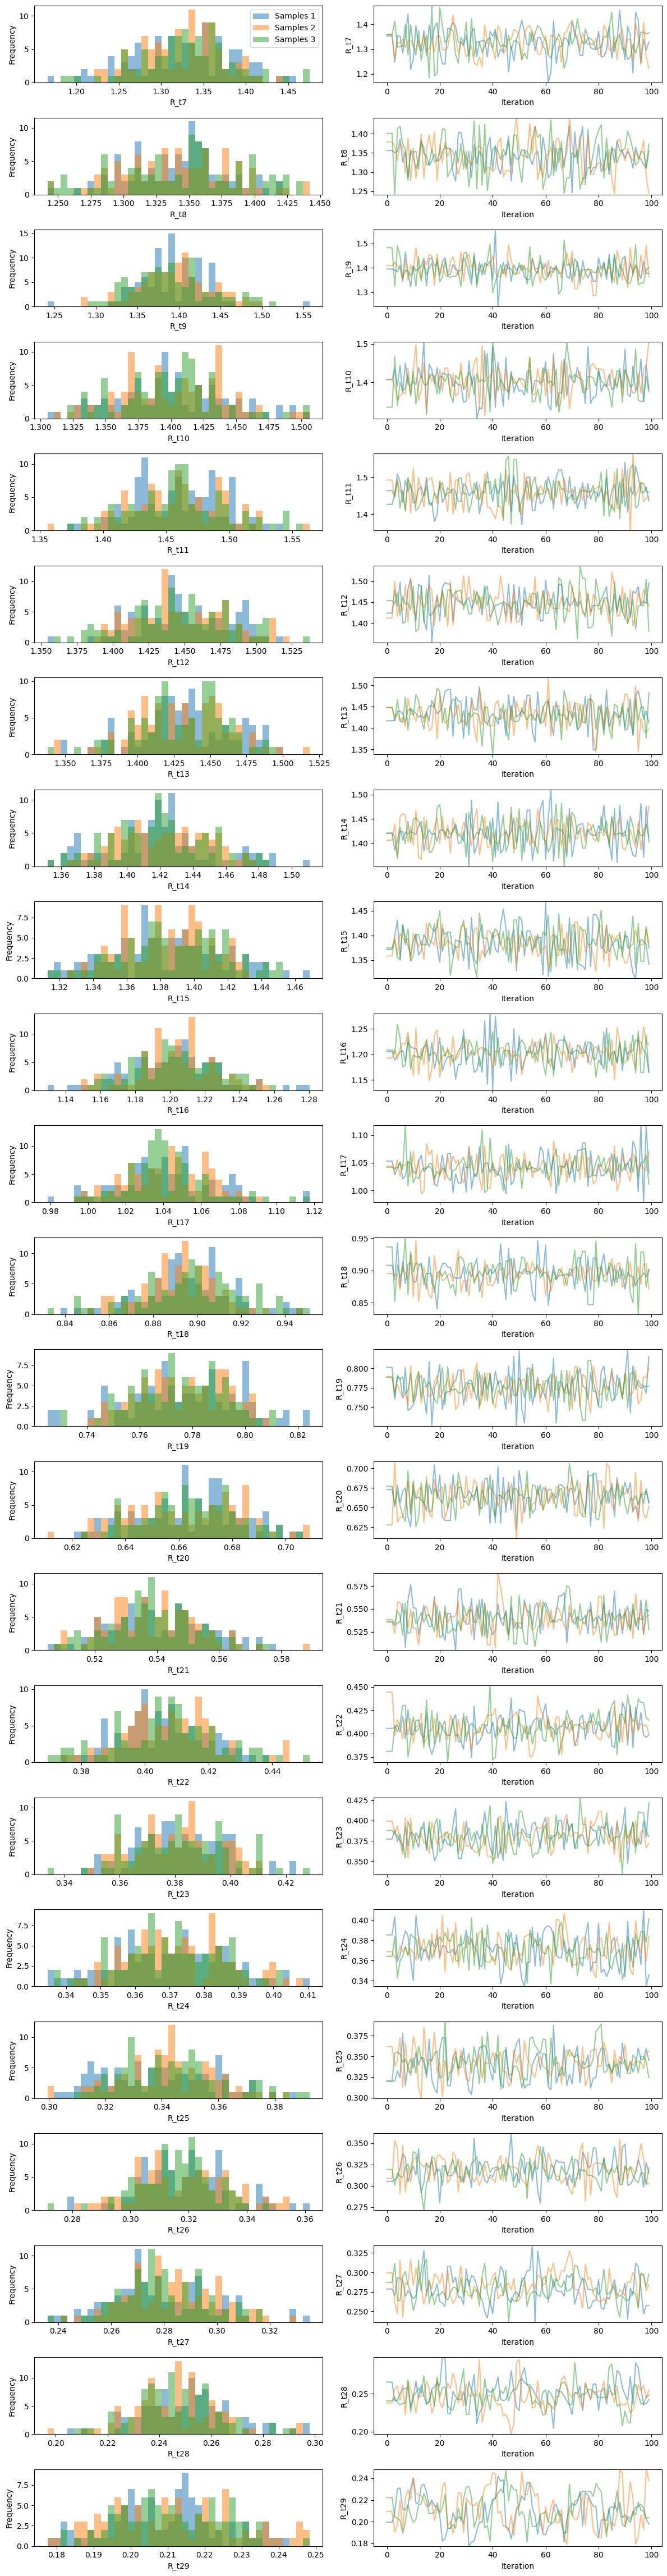

In [6]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 50:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [7]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [8]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[-54.676531544828315, -64.42557496484369, -51.24676372361136, -56.812709590303704, -25.080657178477846, -37.99520836764714, -63.61111591104417, -81.97439474315615, -137.7878981656977, 2842.5884644093453, 2385.6927657107008, 1841.9914214973685, 1304.2856469837716, 761.2732817506184, 174.5053505146643, -376.0040350243798, -434.13168768893223, -404.1177626277203, -422.68246234016254, -429.2039060601382, -454.90384327422356, -462.5971790119365, -471.0312477072875]
[-54.67505374645316, -64.42362602053052, -51.24430819663311, -56.809805230888514, -25.077135072567444, -37.991170797645395, -63.606544793532635, -81.96924363773883, -137.78228709321138, 2842.6370036174694, 2385.738605096261, 1842.0330808951994, 1304.3222464105854, 761.3039214181847, 174.52897005841885, -375.9875553371884, -434.1178279989142, -404.1060429402153, -422.67320260111006, -429.1964463209214, -454.89804331621366, -462.5926390385527, -471.02778772564295]


In [9]:
output_optimisation = inference_new.run_optimisation()[0]

shape = []
rate = []
mean = []

i=0

theta_hat = output_optimisation

for _, t in enumerate(range(R_t_start,num_timepoints)):
    shape.append( a + np.sum(locally_infected_cases[(t-tau):(t+1), :]) )
    sum_var_loc = 0
    sum_var_imp = 0
    for k_inx, k in enumerate(range(t-tau,t+1)):
        for i in range(num_categories):
            vec1 = locally_infected_cases[(k-1)::-1, :] # I_loc_(k-1), ... , I_loc_0
            vec2 = imported_cases[(k-1)::-1, :] # I_imp_(k-1), ... , I_imp_0
            vec3 = serial_interval[:k] # w_1, ... , w_k

            sub_sum_loc = np.multiply(transmissibility, np.matmul(vec3,vec1))
            sub_sum_imp = np.multiply(transmissibility, np.matmul(vec3,vec2))

            sum_var_loc += np.sum(np.multiply(contact_matrix[i, :], sub_sum_loc))  # vector of sum^k_{s=0} w_s I_{k-s}
            sum_var_imp += np.sum(np.multiply(contact_matrix[i, :], sub_sum_imp))  # vector of sum^k_{s=0} w_s I_{k-s}

    rate.append(1/b + sum_var_loc + epsilon * sum_var_imp)
    i += 1


# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

S_vector = np.multiply(np.reciprocal(np.array(shape)-1), np.square(theta_hat))
S = np.diag(S_vector)

# q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta1.mean(),
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13     -12144.7  -12144.7    0:00.0
1     26     -10732.51 -10732.51   0:00.0
2     39     -10732.51 -10785.76   0:00.0
3     52     -10732.51 -12198.31   0:00.1
20    273    -4665.175 -4665.175   0:00.3
40    533    -3348.752 -3435.737   0:00.5
60    793    -3092.566 -3101.545   0:00.7
80    1053   -3005.761 -3010.323   0:01.0
100   1313   -2997.234 -2997.373   0:01.2
120   1573   -2992.828 -2992.882   0:01.4
140   1833   -2992.489 -2992.508   0:01.7
160   2093   -2992.356 -2992.357   0:01.9
180   2353   -2992.336 -2992.336   0:02.2
200   2613   -2992.333 -2992.334   0:02.4
220   2873   -2992.333 -2992.333   0:02.6
223   2899   -2992.333 -2992.333   0:02.7
Halting: No significant change for 100 iterations.
[1.32392898 1.34227469 1.39479923 1.401821   1.45943798 1.44951093
 1.42912169 1.42063928 1.38326024 1.204

In [10]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

## Compute the posterior distribution using STAN

In [11]:
locimp_multicat_model = CmdStanModel(stan_file=os.path.join(
        '../branchpro/stan_models/locimp_multicat.stan'))

locimp_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': locally_infected_cases.astype(np.integer).tolist(),
    'impI': imported_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'epsilon': epsilon}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_24748/2433214683.py:10: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_24748/2433214683.py:11: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [12]:
locimp_fit = locimp_multicat_model.sample(
    data=locimp_multicat_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(locimp_fit)

az.summary(samples)

13:10:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
chain 1 |▍         | 00:00 Status
chain 1 |▉         | 00:10 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:18 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:25 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:31 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:37 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:43 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:49 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:55 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 01:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 01:07 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 01:13 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 01:20 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 01:26 Iteration: 1200 / 2000 [ 60%]  (Sampling)



13:12:24 - cmdstanpy - INFO - CmdStan done processing.
13:12:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'locimp_multicat.stan', line 58, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'locimp_multicat.stan', line 58, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'locimp_multicat.stan', line 58, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'locimp_multicat.stan', line 58, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'locimp_multicat.stan', line 58, column 8 to column 30)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'locimp_multicat.stan', line 58, column 8 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive f

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],1.345,0.052,1.248,1.444,0.001,0.0,7193.0,2372.0,1.0
R[1],1.359,0.045,1.275,1.444,0.001,0.0,7220.0,2188.0,1.0
R[2],1.411,0.043,1.324,1.487,0.001,0.0,6849.0,1892.0,1.0
R[3],1.416,0.038,1.345,1.486,0.000,0.0,9250.0,1997.0,1.0
R[4],1.472,0.037,1.396,1.538,0.000,0.0,8871.0,2340.0,1.0
R[5],1.460,0.035,1.398,1.526,0.000,0.0,8726.0,2447.0,1.0
R[6],1.439,0.030,1.382,1.494,0.000,0.0,7960.0,2480.0,1.0
R[7],1.429,0.031,1.371,1.485,0.000,0.0,6894.0,2130.0,1.0
R[8],1.390,0.027,1.339,1.440,0.000,0.0,7680.0,2223.0,1.0
R[9],1.209,0.025,1.167,1.258,0.000,0.0,8766.0,2039.0,1.0


array([[<Axes: title={'center': 'R\n0'}>,
        <Axes: title={'center': 'R\n0'}>],
       [<Axes: title={'center': 'R\n1'}>,
        <Axes: title={'center': 'R\n1'}>],
       [<Axes: title={'center': 'R\n2'}>,
        <Axes: title={'center': 'R\n2'}>],
       [<Axes: title={'center': 'R\n3'}>,
        <Axes: title={'center': 'R\n3'}>],
       [<Axes: title={'center': 'R\n4'}>,
        <Axes: title={'center': 'R\n4'}>],
       [<Axes: title={'center': 'R\n5'}>,
        <Axes: title={'center': 'R\n5'}>],
       [<Axes: title={'center': 'R\n6'}>,
        <Axes: title={'center': 'R\n6'}>],
       [<Axes: title={'center': 'R\n7'}>,
        <Axes: title={'center': 'R\n7'}>],
       [<Axes: title={'center': 'R\n8'}>,
        <Axes: title={'center': 'R\n8'}>],
       [<Axes: title={'center': 'R\n9'}>,
        <Axes: title={'center': 'R\n9'}>],
       [<Axes: title={'center': 'R\n10'}>,
        <Axes: title={'center': 'R\n10'}>],
       [<Axes: title={'center': 'R\n11'}>,
        <Axes: title

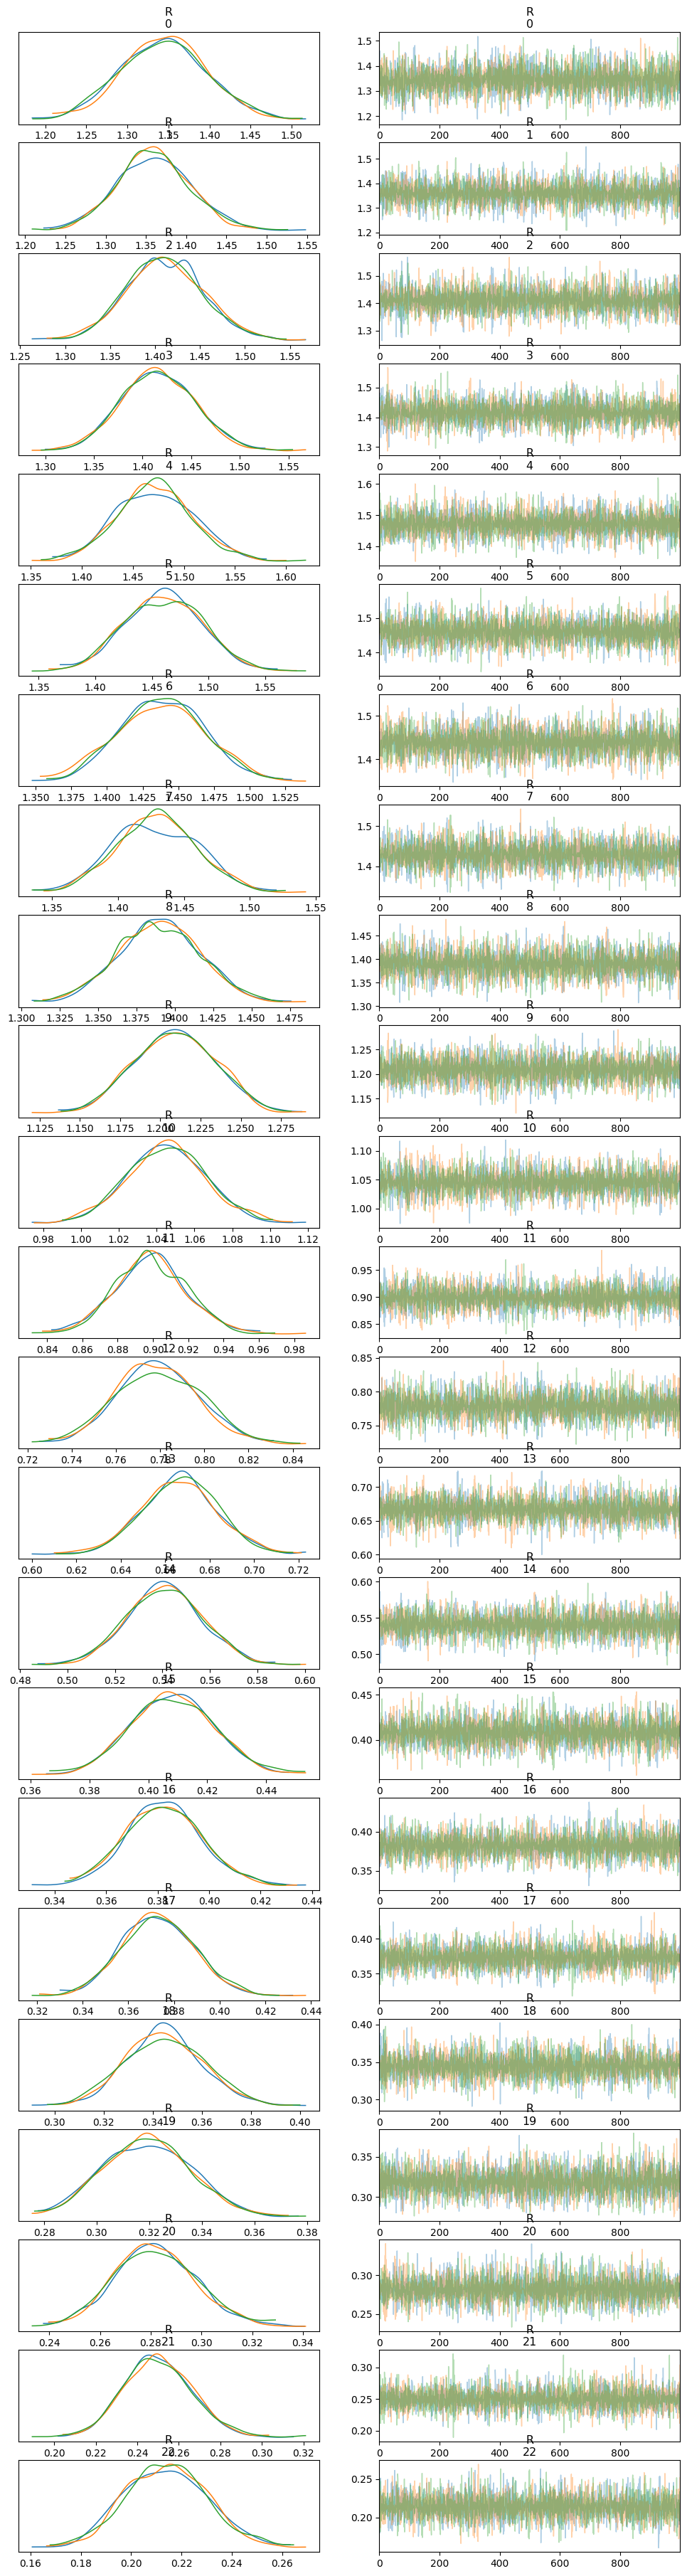

In [13]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [14]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = locimp_fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [15]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

